<a href="https://colab.research.google.com/github/NijilGeorge/semantic_segmentation_unet/blob/main/AML_assign1_segmentation_switch_nodrop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
input_dir="/content/drive/My Drive/deep_learning_assignment/training/data/"
target_dir="/content/drive/My Drive/deep_learning_assignment/training/masks/"
valid_input_dir="/content/drive/My Drive/deep_learning_assignment/testing/data/"
valid_target_dir="/content/drive/My Drive/deep_learning_assignment/testing/masks/"
image_size=(160,160)
print(image_size[1])
num_classes=1
batch_size=1
epoch=15
input_image_paths=sorted([os.path.join(input_dir,fname) for fname in os.listdir(input_dir)])
target_image_paths=sorted([os.path.join(target_dir,fname) for fname in os.listdir(target_dir)])

valid_input_image_paths=sorted([os.path.join(valid_input_dir,fname) for fname in os.listdir(valid_input_dir)])
valid_target_image_paths=sorted([os.path.join(valid_target_dir,fname) for fname in os.listdir(valid_target_dir)])
print("Number of sample:=",len(input_image_paths),len(input_image_paths)==len(target_image_paths))
for input_path,target_path in zip(input_image_paths[:10],target_image_paths[:10]):
  print(input_path+" | "+target_path)



Mounted at /content/drive
160
Number of sample:= 243 True
/content/drive/My Drive/deep_learning_assignment/training/data/P01-0080.jpg | /content/drive/My Drive/deep_learning_assignment/training/masks/P01-0080.jpg
/content/drive/My Drive/deep_learning_assignment/training/data/P01-0100.jpg | /content/drive/My Drive/deep_learning_assignment/training/masks/P01-0100.jpg
/content/drive/My Drive/deep_learning_assignment/training/data/P01-0108.jpg | /content/drive/My Drive/deep_learning_assignment/training/masks/P01-0108.jpg
/content/drive/My Drive/deep_learning_assignment/training/data/P01-0120.jpg | /content/drive/My Drive/deep_learning_assignment/training/masks/P01-0120.jpg
/content/drive/My Drive/deep_learning_assignment/training/data/P01-0128.jpg | /content/drive/My Drive/deep_learning_assignment/training/masks/P01-0128.jpg
/content/drive/My Drive/deep_learning_assignment/training/data/P01-0140.jpg | /content/drive/My Drive/deep_learning_assignment/training/masks/P01-0140.jpg
/content/dri

# **Show some sample images and their corresponding masks.**

--------IMAGE#2------------------


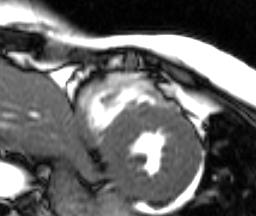

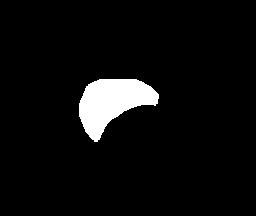

------------------------------------------
--------IMAGE#3------------------


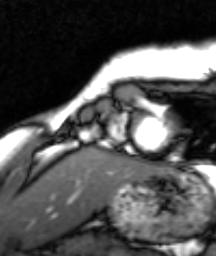

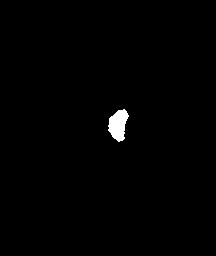

------------------------------------------
--------IMAGE#4------------------


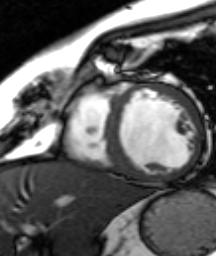

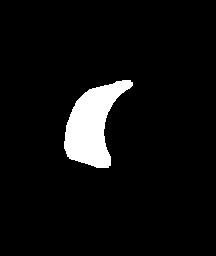

------------------------------------------
--------IMAGE#5------------------


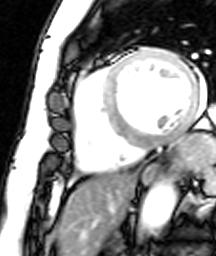

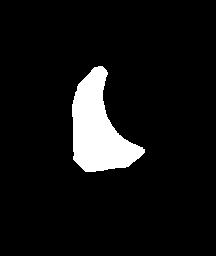

------------------------------------------
--------IMAGE#6------------------


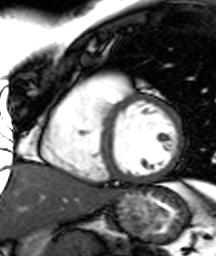

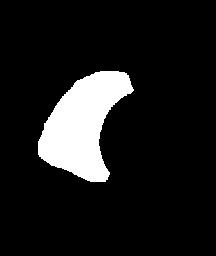

------------------------------------------
--------IMAGE#7------------------


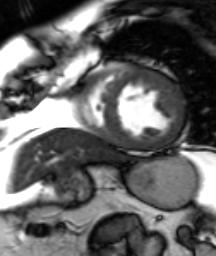

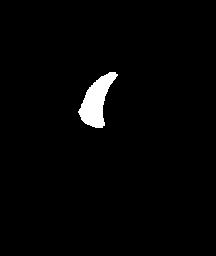

------------------------------------------


In [ ]:
from IPython.display import Image,display
from tensorflow.keras.preprocessing.image import load_img
#import PIL
#from PIL import  ImageOps
i=1
for index in [24,56 ,78,90,156,251]:
  i=i+1
  print("--------IMAGE#"+str(i)+"------------------" )
  index=(index%len(input_image_paths))
  display(Image(filename=input_image_paths[index]))
 # img=PIL.ImageOps.autocontrast(load_img(target_image_paths[index]))
  display(Image(filename=target_image_paths[index]))
  print("------------------------------------------")

# Vectorize batches of data!

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img,array_to_img, img_to_array
from skimage.transform import resize

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
 
class MRI(keras.utils.Sequence):
  def __init__(self,batch_size,img_size,input_image_paths,target_image_paths):
    self.batch_size=batch_size
    self.img_size=img_size
    self.input_image_paths=input_image_paths# these are lists containing the image and mask names
    self.target_image_paths=target_image_paths
  def __len__(self):
    return len(self.target_image_paths)
  def __getitem__(self,idx):
    
    if (idx+1)*self.batch_size>len(self.input_image_paths):
      batch_input_image_paths=self.input_image_paths[idx*self.batch_size:len(self.input_image_paths)]
      batch_target_image_paths=self.target_image_paths[idx*self.batch_size:len(self.input_image_paths)]
    else:
      batch_input_image_paths=self.input_image_paths[idx*self.batch_size:(idx+1)*self.batch_size]
      batch_target_image_paths=self.target_image_paths[idx*self.batch_size:(idx+1)*self.batch_size]
    X=np.zeros(((len(batch_input_image_paths),)+self.img_size+(1,)),dtype="float32")

   
    #(1,)===> its single channel input
    Y=np.zeros(((len(batch_target_image_paths),)+self.img_size+(1,)),dtype="float32")
    index=0
    for image_path,target_path in zip(batch_input_image_paths,batch_target_image_paths):


      img=load_img(image_path,grayscale=True)
      x_img = img_to_array(img)
      x_img = resize(x_img, self.img_size+(1,), mode='constant', preserve_range=True)
      
      X[index]=x_img/255
      img=load_img(target_path,grayscale=True)
      x_img = img_to_array(img)
      x_img = resize(x_img, self.img_size+(1,), mode='constant', preserve_range=True)
      Y[index]=x_img/255
      index+=1
    return X,Y
  

Found GPU at: /device:GPU:0


# VANILLA UNET **MODEL**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
regrate=0.00005
dpout=0.0
regularizer = tf.keras.regularizers.L1L2(regrate*0.2,regrate)
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               kernel_regularizer=regularizer, bias_regularizer=regularizer,padding="same")(input_tensor) #
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # second layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               kernel_regularizer=regularizer, bias_regularizer=regularizer,padding="same")(x) #
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def get_model( img_size, num_classes,dropout=0.5, batchnorm=True,n_filters=16):
    # contracting path
    input_img=layers.Input(shape=img_size+(1,))
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = layers.MaxPooling2D((2, 2)) (c1)
    p1 = layers.Dropout(dropout*0.1)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = layers.MaxPooling2D((2, 2)) (c2)
    p2 = layers.Dropout(dropout*0.25)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = layers.MaxPooling2D((2, 2)) (c3)
    p3 = layers.Dropout(dropout*0.5)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = layers.Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = layers.Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = layers.concatenate([u6, c4])
    u6 = layers.Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = layers.Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = layers.concatenate([u7, c3])
    u7 = layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = layers.Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = layers.concatenate([u8, c2])
    u8 = layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = layers.Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    u9 = layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid') (c9)
    model = keras.Model(inputs=[input_img], outputs=[outputs])
    return model

model=get_model(img_size=image_size,num_classes=1,dropout=dpout,batchnorm=True)

,

In [ ]:
import tensorflow as tf

import keras
import keras.backend as K
def dice_loss(true,target):
  return tf.subtract(1.0,tf.divide(tf.add(tf.reduce_sum(tf.multiply(tf.multiply(2.0,true),target)),0.0000001),tf.add(tf.add(tf.reduce_sum(true),tf.reduce_sum(target)),0.000001)))
def focal_loss(true,target):
  gamma=1
  pt=tf.multiply(keras.backend.log(tf.add(target,0.000001)),true)
  o_pt=tf.multiply(keras.backend.log(tf.subtract(1.0000001,target)),tf.subtract(1.0,true))
  BCE=tf.add(pt,o_pt)
  weighted=tf.tf.multiply(-1.0,tf.pow(tf.subtract(1.0,BCE),gamma))
  return tf.multiply(target,true)+tf.multiply(true,np.subtract)
def MSE(true,target):
  
  return tf.sqrt(tf.divide( tf.reduce_sum( tf.pow( tf.subtract(true,target) ,2) ) , tf.cast( tf.size(true),tf.float32)))
def switching_loss(true,target):
  lam=0.75
  T=.5
 
  LD=tf.subtract(1.0,tf.divide(tf.add(tf.reduce_sum(tf.multiply(tf.multiply(2.0,true),target)),0.0000001),tf.add(tf.add(tf.reduce_sum(true),tf.reduce_sum(target)),0.000001)))
  LI=tf.subtract(1.0,tf.divide(tf.add(tf.reduce_sum(tf.multiply(tf.multiply(2.0,tf.subtract(1.0,true)),tf.subtract(1.0,target))),0.0000001),tf.add(tf.add(tf.reduce_sum(tf.subtract(1.0,true)),tf.reduce_sum(tf.subtract(1.0,target))),0.000001)))
  
  pt=tf.multiply(keras.backend.log(tf.add(target,0.000001)),true)
  o_pt=tf.multiply(keras.backend.log(tf.subtract(1.0000001,target)),tf.subtract(1.0,true))
  BCE=   tf.divide(tf.multiply(-1.000,tf.add(pt,o_pt)) ,tf.cast( tf.size(true),tf.float32))
  LC=tf.reduce_sum(BCE)

  # LC=tf.reduce_sum(tf.multiply(-1.0,tf.multiply(true,keras.backend.log(tf.add(target,0.000001)))))
  Cf_Ct=tf.divide(tf.reduce_sum(true),tf.cast(tf.size(true),tf.float32))
  if Cf_Ct>T:
    LOSS=tf.add(LC,tf.add(tf.multiply(lam,LD),tf.multiply(tf.subtract(1.0,lam),LI)))
  else:
    LOSS=tf.add(LC,tf.add(tf.multiply(lam,LI),tf.multiply(tf.subtract(1.0,lam),LD)))
  return LOSS
def dice_coefficient(true,target):
  bin_target=tf.round(target)
  return tf.divide(tf.multiply(2.0,tf.reduce_sum(tf.multiply(bin_target,true))),tf.add(tf.reduce_sum(true),tf.reduce_sum(bin_target)))
#def DiceBCELoss(targets, inputs):    
       
    #flatten label and prediction tensors
   # inputs = K.flatten(inputs)
   # targets = K.flatten(targets)
    
    #BCE = keras.losses.binary_crossentropy(targets, inputs)
    #tf.sum(tf.tensordot(targets,inputs))
    #dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    #Dice_BCE = BCE + dice_loss
    
    #return BCE


callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_MRI_switch.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
train_gen=MRI(batch_size=batch_size,img_size=image_size,input_image_paths=input_image_paths,target_image_paths=target_image_paths)
validation_gen=MRI(batch_size=1,img_size=image_size,input_image_paths=valid_input_image_paths,target_image_paths=valid_target_image_paths)
model.compile(optimizer="adam", loss=switching_loss, metrics=[dice_coefficient])



history=model.fit(train_gen,epochs=epoch,validation_data=validation_gen,callbacks=callbacks)




/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Epoch 1/15
243/243 [==============================] - ETA: 0s - loss: 0.8113 - dice_coefficient: 0.5961
Epoch 00001: val_loss improved from inf to 0.66406, saving model to model_MRI_switch.h5
243/243 [==============================] - 11s 44ms/step - loss: 0.8113 - dice_coefficient: 0.5961 - val_loss: 0.6641 - val_dice_coefficient: 0.3286
Epoch 2/15
241/243 [============================>.] - ETA: 0s - loss: 0.4750 - dice_coefficient: 0.7025
Epoch 00002: val_loss did not improve from 0.66406
243/243 [==============================] - 10s 39ms/step - loss: 0.4742 - dice_coefficient: 0.7038 - val_loss: 0.9768 - val_dice_coefficient: 0.3264
Epoch 3/15
243/243 [==============================] - ETA: 0s - loss: 0.3710 - dice_coefficient: 0.7609
Epoch 00003: val_loss improved from 0.66406 to 0.36599, saving model to model_MRI_switch.h5
243/243 [==============================] - 10s 39ms/step - loss: 0.3710 - dice_coefficient: 0.7609 - val_loss: 0.3660 - val_dice_coefficient: 0.7102
Epoch 4/15

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


orig dim: (256, 216)
resized dim: (160, 160)

input_image


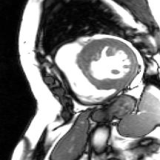


target_image


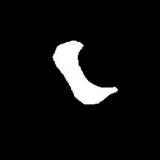


predicted


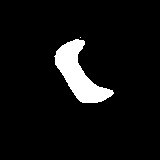

____________________________________________________
orig dim: (256, 216)
resized dim: (160, 160)

input_image


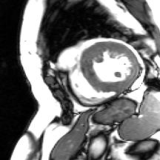


target_image


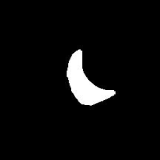


predicted


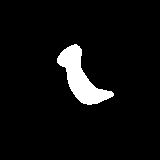

____________________________________________________
orig dim: (256, 216)
resized dim: (160, 160)

input_image


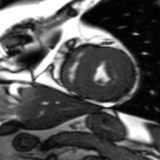


target_image


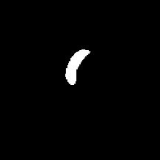


predicted


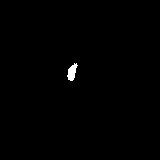

____________________________________________________
orig dim: (256, 216)
resized dim: (160, 160)

input_image


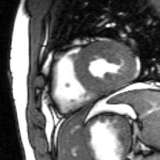


target_image


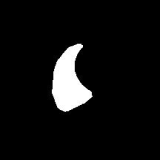


predicted


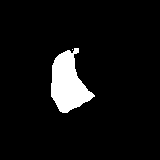

____________________________________________________
orig dim: (256, 216)
resized dim: (160, 160)

input_image


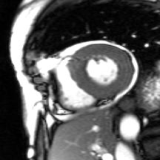


target_image


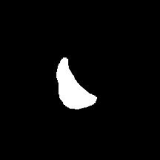


predicted


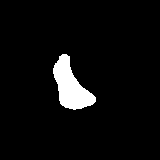

____________________________________________________
orig dim: (216, 256)
resized dim: (160, 160)

input_image


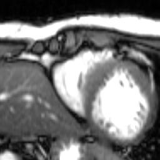


target_image


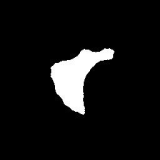


predicted


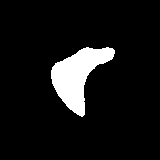

____________________________________________________
orig dim: (216, 256)
resized dim: (160, 160)

input_image


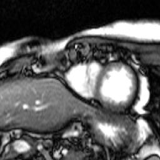


target_image


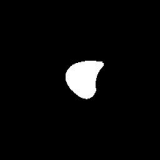


predicted


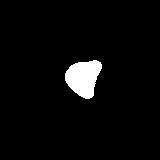

____________________________________________________
orig dim: (256, 216)
resized dim: (160, 160)

input_image


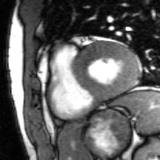


target_image


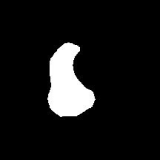


predicted


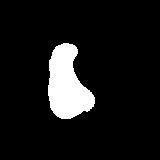

____________________________________________________


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
val_preds=model.predict(validation_gen)
for i in [1,3,82,34,108,53,73,30]:
  img = cv2.imread(valid_input_image_paths[i], cv2.IMREAD_UNCHANGED) 
  print("orig dim:", img.shape)
  resized = cv2.resize(img,image_size, interpolation = cv2.INTER_AREA) 
  print("resized dim:", resized.shape)
  print()
  print("input_image")
  cv2_imshow( resized)

 
  img = cv2.imread(valid_target_image_paths[i], cv2.IMREAD_UNCHANGED) 

  resized = cv2.resize(img,image_size, interpolation = cv2.INTER_AREA) 
  print()
  print("target_image") 
  cv2_imshow( resized)

 
  im=(255*np.round(np.array(val_preds[i])))
  print()
  print("predicted")

  cv2_imshow( im)
  print("____________________________________________________")

dict_keys(['loss', 'dice_coefficient', 'val_loss', 'val_dice_coefficient', 'lr'])


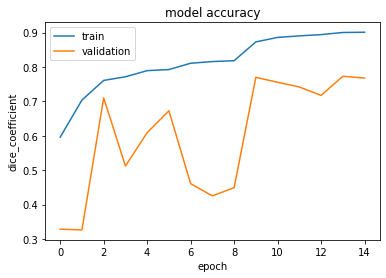

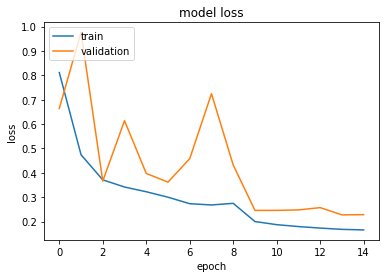

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('model accuracy')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('/content/drive/My Drive/deep_learning_assignment/all_regularization_0.2*L11*L2{}_dropout_{}inc_correct_loss_dice.png'.format(regrate,dpout))
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('/content/drive/My Drive/deep_learning_assignment/all_regularization_0.2*L11*L2{}_dropout_{}inc_correct_loss_loss.png'.format(regrate,dpout))
plt.show()